# Functions

Solution rejected.
Reducing trust region size. Solving again with radius =  66.66666666666667
iter            max_viol             dJ          c_lin         c_nlin       lin_cost    nonlin_cost              J             dX             TR
1               0.261898        493.712      0.0494712      0.0494712        3.46299           71.4       0.494712       0.352796        66.6667
Solution rejected.
Reducing trust region size. Solving again with radius =  44.44444444444445
iter            max_viol             dJ          c_lin         c_nlin       lin_cost    nonlin_cost              J             dX             TR
2               0.261899        493.712      0.0494712      0.0494712        3.46299        71.4001       0.494712       0.352797        44.4444
Solution rejected.
Reducing trust region size. Solving again with radius =  29.629629629629633
iter            max_viol             dJ          c_lin         c_nlin       lin_cost    nonlin_cost              J             dX        

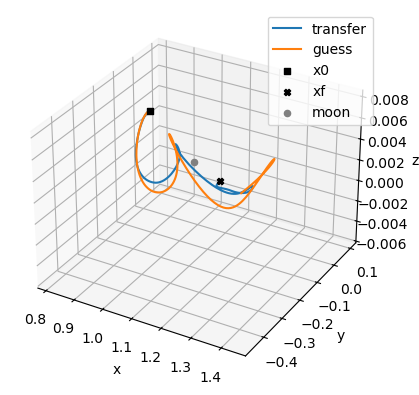

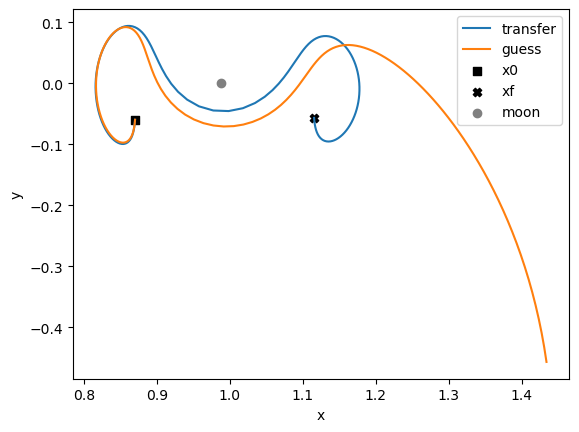

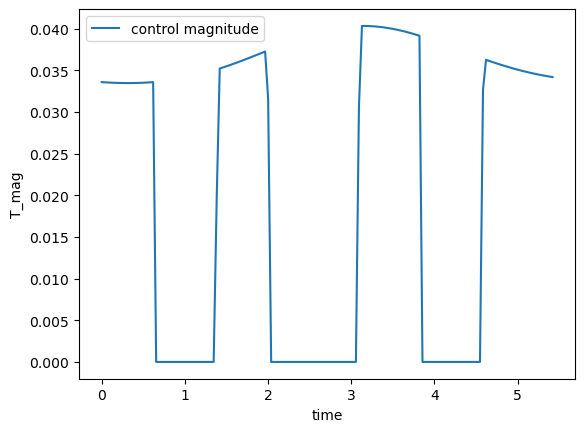

In [3]:
import sys
import os

# Construct the full path to the directory containing the package
project_path = '/Users/hofmannc/git/apolune'

# Add the directory to sys.path
sys.path.append(project_path)


import numpy as np
from copy import deepcopy
from scipy.integrate import odeint
import dynamics.crtbp_dynamics_control as crtbp
# import dynamics.crtbp_dynamics as crtbp
# import dynamics_coeff.dynamics_general_jit as dyn_coeff
import dynamics_coeff.dynamics_general_control_jit as dyn_coeff
# import dynamics_coeff.dynamics_general_control as dyn_coeff
import propagation.propagator as propagation
import cvxpy as cvx
import matplotlib.pyplot as plt
import spiceypy as spice
import init.load_kernels as krn
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
import time as tm
import scp_core_low_thrust as scp_core
import dynamics_coeff.homotopy as homotopy
import scp_solve_low_thrust as scp_solve
import copy


def initial_guess(auxdata):
    n_x = auxdata['problem']['n_x']
    n_u = auxdata['problem']['n_u']
    N = auxdata['problem']['N']
    
    time = auxdata['param']['time_vec']
    x0 = auxdata['param']['x0']
#     x0[3:6] *= 1.001 # converges
#     x0[3:6] *= 1.004 # failed
#     x0[3:6] *= 1.002 # converges

#     x0[3:6] *= 1.002445 # converges for crtbp when propagating nb dynamics
#     x0 *= 1.000005 # 
    
    
    if auxdata['problem']['free_tf'] == 1:
        tf = auxdata['param']['tf']
        time = time * tf
        p_guess = np.array([tf])
    else:
        p_guess = np.empty(0)
    
    u_guess = np.zeros((N, n_u))
    x_guess = propagation.propagate(crtbp.dynamics, x0, np.zeros(n_u), p_guess, time, auxdata)
    # x_guess = propagation.propagate(crtbp.dynamics, x0, u_guess, p_guess, time, auxdata)
#     x_guess = propagation.propagate(dyn_coeff.dynamics, x0, np.zeros(n_u), p_guess, time, auxdata)
    

    return x_guess, u_guess, p_guess



mu_earth_moon = 1.21506683e-2
LU = 3.84405000e5 # km
TU = 375197.5822850085 # seconds
VU = LU / TU # km/s
ACU = VU / TU # Acceleration unit [km/s^2]

g0_dim = 9.80665e-3 # [km s^-2]

foh_flag = 1

# crtbp
mu = mu_earth_moon

# bcrfbp
mu_sun = 3.28900541e5 # adim
a_sun = 3.88811143e2 # adim
om_sun = -9.25195985e-1
sun_angle_t0 = 0.0

# rnbp_rpf
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

# spacecraft data
m0_dim = 22.6 # [kg]
Tmax_dim = 2.2519*1e-3 # [N]
# Tmax_dim = 2.2519*1e-2 # [N]
Isp_dim = 3067 # [s]

MU = m0_dim
FU = MU * ACU / 1e-3

m0 = m0_dim / MU
Tmax = Tmax_dim / FU 
Isp = Isp_dim / TU
g0 = g0_dim / ACU

observer_id = 0

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 

id_primary = id_ear[0]
id_secondary = id_moo[0]

id_bodies = np.array([id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]])
naif_id_bodies = np.array([id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]])
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

# MU = mu_bodies[id_primary] + mu_bodies[id_secondary]

# epoch_t0 = spice.str2et('23 September 2022 00:00:00 TDB')
epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
reference_frame = "j2000"
reference_frame_encoded = rnbp_utils.frame_encoder("J2000")
mu_p = mu_bodies[id_primary]
mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]
naif_id_s = naif_id_bodies[id_secondary]

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0
tau_f = 100.0
t0 = 0.0
n_points = 5000
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
# tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)
tau_vec, t_vec, l_vec = rnbp_utils.compute_time_distance(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)
# tau_vec_v2, t_vec_v2, l_vec = rnbp_utils.compute_time_distance(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)
# dtau_vec = tau_vec_v2 - tau_vec
# dt_vec = t_vec_v2 - t_vec
# dtau_max = max(dtau_vec.min(), dtau_vec.max(), key=abs)
# dt_max = max(dt_vec.min(), dt_vec.max(), key=abs)

pos_p = np.array([-mu, 0.0, 0.0])
pos_s = np.array([1-mu, 0.0, 0.0])

n_x = 7
n_u = 4
N = 150
Ns = N - 1

# 0: fixed final time, 1: free final time
# NOTE: i only implemented the case for free_tf = 0 so far
free_tf = 0

# model = 1 # crtbp
# model = 2 # bcrfbp
model = 3 # rnbp_rpf
# model = 4 # rnbp_rpf with fft, interpolation, and homotopy

if model == 4: 
    # Define parameters for approximation methods
    n_components_fft = 100 # not used for now since not removing high frequency components
    num_segments_piecewise = 20
    polynomial_degree = 3
    
    # Select homotopy method and extrapolation point
    sel_homotopy = 1 # 1: FFT ; 2: Piecewise ; 3: Polynomial
    if sel_homotopy == 1:
        homotopy_param = n_components_fft
    elif sel_homotopy == 2:
        homotopy_param = num_segments_piecewise
    elif sel_homotopy == 3:
        homotopy_param = polynomial_degree
    
    coeff_3bp_tmp, coeff_nbp_list, f_precomputed_list = homotopy.get_homotopy_coefficients(sel_homotopy, homotopy_param, tau_vec, t_vec, id_primary, id_secondary, mu_bodies, naif_id_bodies, observer_id, reference_frame_encoded, epoch_t0, use_jit=True)
    coeff_nbp = np.array((coeff_nbp_list), dtype=np.float64)
    f_precomputed = np.array((f_precomputed_list), dtype=np.float64)
    coeff_3bp = np.ascontiguousarray(coeff_3bp_tmp)



# node indices where maneuvers are applied; numpy array within [0, Ns]
# man_index = np.array([0, 30, 60, Ns])
# man_index = np.array([0, 50, Ns])
# man_index = np.array([0, Ns])

# initial and final boundary conditions
# x0 = np.array([8.2338046140454002e-01, 0, 1.3886061447073000e-02, 0, 1.2947638542136800e-01, 0]) # adim
# xf = np.array([1.1194488032482977e+00, 2.3502976908423845e-13, -1.1371675247773910e-02, 2.2969820490104098e-13, 1.7876223257953414e-01, -2.7620527393024119e-13]) # adim
# t0 = 0.0
# tf = 6.9083604301186052e-01

# x0 = np.array([0.870183, -0.059444, 0, -0.010471, -0.175136, 0, 0]) # adim; original
# x0 = np.array([0.870186, -0.059447, 1e-3, -0.0105, -0.17514, 1e-3, 0]) # adim, mod
x0 = np.array([0.870186, -0.059447, 5e-3, -0.0105, -0.17514, 1e-3, 0]) # adim, mod
xf = np.array([1.11559, -0.056398, 0, -0.008555, 0.157211, 0]) # adim
t0 = 0.0
tf = 12.34 / 4.34811305 * 1.91 # adim

x0_dim = copy.deepcopy(x0)
xf_dim = copy.deepcopy(xf)
x0_dim[:3] *= LU
x0_dim[3:6] *= VU
xf_dim[:3] *= LU
xf_dim[3:6] *= VU
tf_dim = tf * TU

LU_t0 = np.interp(t0, tau_vec, l_vec)
LU_tf = np.interp(tf, tau_vec, l_vec)
TU_t0 = np.sqrt(LU_t0**3 / (mu_p + mu_s))
TU_tf = np.sqrt(LU_tf**3 / (mu_p + mu_s))
VU_t0 = LU_t0 / TU_t0
VU_tf = LU_tf / TU_tf

# x0[:3] = x0_dim[:3] / LU_t0
# x0[3:6] = x0_dim[3:6] / VU_t0
# xf[:3] = xf_dim[:3] / LU_tf
# xf[3:6] = xf_dim[3:6] / VU_tf
# tf = tf_dim / TU_tf

# bounds for states, controls, and dv per maneuver
states_lower = np.array([-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, np.log(0.1)])
states_upper = np.array([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, np.log(1.0)])
controls_lower = np.array([-10.0, -10.0, -10.0, 0.0])
controls_upper = np.array([10.0, 10.0, 10.0, 10.0])

# n_p: number of free parameters in the optimization
# here: no free parameters
# n_man = len(man_index)
n_p = 0

tf_ind = 0

# lower and upper bounds of the free variable vector p
p_lower = np.empty(0)
p_upper = np.empty(0)

# functions for dynamics and corresponding jacobian
# jacobian_x_function = crtbp.jacobian_x
# jacobian_u_function = crtbp.jacobian_u
# dynamics_function = crtbp.dynamics

jacobian_x_function = dyn_coeff.jacobian_x
jacobian_u_function = dyn_coeff.jacobian_u
dynamics_function = dyn_coeff.dynamics

# tolerances for the integrator
# we use different values for piecewise integration (from t_k to t_k+1) and full integration (from t0 to tf)
ode_atol_piecewise = 1e-10
ode_rtol_piecewise = 1e-10
ode_atol = 1e-12
ode_rtol = 1e-12

# discretized time vector
time = np.linspace(t0, tf, N)

# trust region parameters
tr_dict = {}
tr_dict['radius'] = 100.0
tr_dict['rho'] = 100.0
tr_dict['rho0'] = 0.01
tr_dict['rho1'] = 0.2
tr_dict['rho2'] = 0.85
tr_dict['alpha'] = 1.5
tr_dict['beta'] = 1.5
tr_dict['delta'] = 1.0
tr_dict['alpha_min'] = 1.01
tr_dict['alpha_max'] = 4.0
tr_dict['beta_min'] = 1.01
tr_dict['beta_max'] = 4.0
tr_dict['radius_min'] = 1e-7
tr_dict['radius_max'] = 500.0


# -----
# some internal definitions -> probably no need to change anything here for now

x_len = N*n_x
u_len = N*n_u
t_len = 0
p_len = n_p

xu_len = x_len + u_len
sol_len = xu_len + t_len + p_len
x_ind = slice(0, x_len) 
u_ind = slice(x_len, xu_len)
p_ind = slice(xu_len, xu_len+p_len)
tf_ind_sol = xu_len + tf_ind

stm_x_len = n_x*n_x
stm_u_len = n_x*n_u
stm_t_len = n_x * free_tf
stm_const_len = n_x

V_len = n_x + stm_x_len + 2*stm_u_len + stm_t_len + stm_const_len
    
x_ind_stm = slice(0, n_x)
stm_x_ind = slice(n_x, stm_x_len+n_x)
stm_uk_ind = slice(stm_x_len+n_x, stm_x_len+n_x+stm_u_len)
stm_uk1_ind = slice(stm_x_len+n_x+stm_u_len, stm_x_len+n_x+stm_u_len+stm_u_len)
stm_t_ind = slice(stm_x_len+n_x+stm_u_len+stm_u_len, stm_x_len+n_x+stm_u_len+stm_u_len+stm_t_len)
stm_const_ind = slice(stm_x_len+n_x+stm_u_len+stm_u_len+stm_t_len, stm_x_len+n_x+stm_u_len+stm_u_len+stm_t_len+stm_const_len)

V0 = np.zeros(V_len)
V0[stm_x_ind] = np.identity(n_x).flatten()
 
x_stm = np.zeros((N,n_x))
stm_x = np.zeros((Ns,n_x*n_x))
stm_uk = np.zeros((Ns,n_x*n_u))
stm_uk1 = np.zeros((Ns,n_x*n_u))
stm_t = np.zeros((Ns,stm_t_len))
stm_const = np.zeros((Ns,stm_const_len))

if free_tf == 1:
    time = np.linspace(0.0, 1.0, N)
else:
    time = np.linspace(t0, tf, N)


scaling_dict = {'LU': LU, 'VU': VU, 'TU': TU, 'ACU': ACU, 'FU': FU, 'MU': MU}
lengths_dict = {'x_len': x_len, 'u_len': u_len, 'xu_len': xu_len, 'p_len': p_len, 't_len': t_len, 'sol_len': sol_len, 'stm_x_len': stm_x_len, 'stm_u_len': stm_u_len, 'stm_t_len': stm_t_len, 'stm_const_len': stm_const_len, 'V_len': V_len}
indices_dict = {'x_ind': x_ind, 'u_ind': u_ind, 'p_ind': p_ind, 'tf_ind': tf_ind, 'tf_ind_sol': tf_ind_sol, 'x_ind_stm': x_ind_stm, 'stm_x_ind': stm_x_ind, 'stm_uk_ind': stm_uk_ind, 'stm_uk1_ind': stm_uk1_ind, 'stm_t_ind': stm_t_ind, 'stm_const_ind': stm_const_ind}
problem_dict = {'n_x': n_x, 'n_u': n_u, 'n_p': n_p, 'N': N, 'Ns': Ns, 'free_tf': free_tf, \
    'dynamics': dynamics_function, 'jacobian_x': jacobian_x_function, 'jacobian_u': jacobian_u_function, \
    'model': model}
param_dict = {'mu': mu, 't0': t0, 'tf': tf, 'x0': x0, 'xf': xf, 'time_vec': time, \
    'g0': g0, 'Isp': Isp, 'Tmax': Tmax, 'g0_dim': g0_dim, 'Isp_dim': Isp_dim, 'Tmax_dim': Tmax_dim, \
    'ode_atol': ode_atol, 'ode_rtol': ode_rtol, 'ode_atol_piecewise': ode_atol_piecewise, 'ode_rtol_piecewise': ode_rtol_piecewise}
boundaries_dict = {'states_lower': states_lower, 'states_upper': states_upper, 'controls_lower': controls_lower, 'controls_upper': controls_upper, \
    'p_lower': p_lower, 'p_upper': p_upper}
discretization_dict = {'foh_flag': foh_flag, 'V0': V0, 'x': x_stm, 'stm_x': stm_x, 'stm_uk': stm_uk, 'stm_uk1': stm_uk1, 'stm_t': stm_t, 'stm_const': stm_const}

auxdata = {'problem': problem_dict, 'lengths': lengths_dict, 'indices': indices_dict, 'param': param_dict, 'discretization': discretization_dict, 'boundaries': boundaries_dict, \
    'scaling': scaling_dict}


auxdata["g0"] = g0
auxdata["Isp"] = Isp
auxdata["Tmax"] = Tmax
auxdata["g0_dim"] = g0_dim
auxdata["Isp_dim"] = Isp_dim
auxdata["Tmax_dim"] = Tmax_dim
auxdata["model"] = model

# for bcrfbp
auxdata["mu_crtbp"] = mu
auxdata["mu_sun"] = mu_sun
auxdata["om_sun"] = om_sun
auxdata["sun_angle_t0"] = sun_angle_t0
auxdata["a_sun"] = a_sun

# for rnbp_rpf
auxdata["id_primary"] = id_primary
auxdata["id_secondary"] = id_secondary
auxdata["mu_bodies"] = mu_bodies
auxdata["naif_id_bodies"] = naif_id_bodies
auxdata["observer_id"] = observer_id
# auxdata["reference_frame"] = reference_frame # needed if no numba / jit is used
auxdata["reference_frame"] = reference_frame_encoded # needed for numba and jit
auxdata["epoch_t0"] = epoch_t0
auxdata["tau_vec"] = tau_vec
auxdata["t_vec"] = t_vec
auxdata["l_vec"] = l_vec
auxdata["mu_p"] = mu_p
auxdata["mu_s"] = mu_s


#for homotopy
if model == 4:
    homot_param = 1.0 # Homotopy parameter (0 <= eps <= 1), would update this with a function in the future
    auxdata['coeff_3bp'] = coeff_3bp
    auxdata['coeff_nbp'] = coeff_nbp
    auxdata['f_precomputed'] = f_precomputed
    auxdata['homot_param'] = homot_param
    auxdata['sel_homotopy'] = sel_homotopy

# print("coeff_3bp.shape: ", coeff_3bp.shape)
# print("coeff_nbp.shape: ", coeff_nbp.shape)
# print("f_precomputed.shape: ", f_precomputed.shape)

# print("type coeff_3bp: ", type(coeff_3bp))
# print("type coeff_nbp: ", type(coeff_nbp))
# print("type f_precomputed: ", type(f_precomputed))

# generate initial guess 
state_guess, control_guess, p_guess = initial_guess(auxdata)

guess_dict = {}
guess_dict['state'] = state_guess
guess_dict['control'] = control_guess
guess_dict['p'] = p_guess
guess_dict['time'] = time

# plt.figure()
# ax = plt.axes(projection ='3d')
# ax.plot(state_guess[:,0], state_guess[:,1], state_guess[:,2], label='guess')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# plt.legend()
# plt.show()

scp_data = {}

scp_data['verbose_solver'] = False

scp_data['feasibility_tol'] = 1e-7
scp_data['optimality_tol'] = 1e-4
scp_data['step_tol'] = 1e-8

scp_data['max_iterations'] = 100
scp_data['factor_nonlin'] = 10.0
scp_data['factor_lin'] = 10.0

scp_data['objective_old'] = 1e-3


solution_data = scp_solve.solve(guess_dict, scp_data, tr_dict, auxdata)

state_sol = solution_data['state']
control_sol = solution_data['control']
mass = np.exp(state_sol[:,-1])
mf_kg = mass[-1] * MU
u_mag = control_sol[:,-1]
T_mag = mass * u_mag
print("mf in kg: ", mf_kg)

pos_secondary = np.array([1-mu, 0.0, 0.0])
pos_sc_secondary = np.zeros((N,3))
for i in range(N):
    pos_sc_secondary[i] = state_sol[i, :3] - pos_secondary

pos_sc_secondary_norm = np.linalg.norm(pos_sc_secondary, axis=1)
dist_min = np.min(pos_sc_secondary_norm)
dist_max = np.max(pos_sc_secondary_norm)
print("min distance between spacecraft and moon (adim): ", dist_min)
print("min distance between spacecraft and moon (km): ", dist_min*LU)
print("max distance between spacecraft and moon (adim): ", dist_max)
print("max distance between spacecraft and moon (km): ", dist_max*LU)


# 3D Trajectory Plot
plt.figure(1)
ax = plt.axes(projection='3d')
ax.plot(state_sol[:, 0], state_sol[:, 1], state_sol[:, 2], label='transfer')
ax.plot(state_guess[:, 0], state_guess[:, 1], state_guess[:, 2], label='guess')
ax.scatter(x0[0], x0[1], x0[2], marker = 's', color = [0, 0, 0], label='x0')
ax.scatter(xf[0], xf[1], xf[2], marker = 'X', color = [0, 0, 0], label='xf')
# ax.scatter(pos_p[0], pos_p[1], pos_p[2], marker = 'o', color = [0, 0.4470, 0.7410], label='earth')
ax.scatter(pos_s[0], pos_s[1], pos_s[2], marker = 'o', color = [0.5, 0.5, 0.5], label='moon')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()  # Ensure legend is within the figure

# 2D Projection (x-y)
plt.figure(2)
plt.plot(state_sol[:, 0], state_sol[:, 1], label='transfer')
plt.plot(state_guess[:, 0], state_guess[:, 1], label='guess')
plt.scatter(x0[0], x0[1], marker = 's', color = [0, 0, 0], label='x0')
plt.scatter(xf[0], xf[1], marker = 'X', color = [0, 0, 0], label='xf')
# plt.scatter(pos_p[0], pos_p[1], marker = 'o', color = [0, 0.4470, 0.7410], label='earth')
plt.scatter(pos_s[0], pos_s[1], marker = 'o', color = [0.5, 0.5, 0.5], label='moon')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()  # Legend must be added to the correct figure

# Control Magnitude Plot
plt.figure(3)
plt.plot(time, T_mag, label='control magnitude')
plt.xlabel("time")
plt.ylabel("T_mag")
plt.legend()  # Ensure legend is added here

# Show all figures
plt.show()


# plt.figure(1)
# ax = plt.axes(projection ='3d')
# ax.plot(state_sol[:,0], state_sol[:,1], state_sol[:,2], label='transfer')
# ax.plot(state_guess[:,0], state_guess[:,1], state_guess[:,2], label='guess')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# plt.legend()
# 
# fig, ax = plt.subplots()
# ax.plot(state_sol[:,0], state_sol[:,1], label='transfer')
# ax.plot(state_guess[:,0], state_guess[:,1], label='guess')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# 
# plt.figure(2)
# plt.plot(time, u_mag)
# 
# plt.legend()
# plt.show()

    


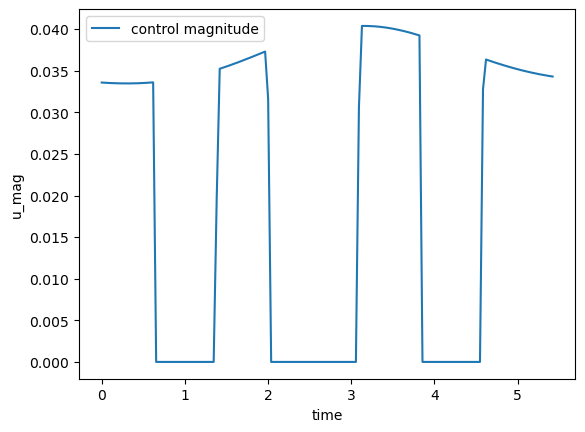

In [4]:
plt.figure(4)
plt.plot(time, u_mag, label='control magnitude')
plt.xlabel("time")
plt.ylabel("u_mag")
plt.legend()  # Ensure legend is added here

# Show all figures
plt.show()

In [ ]:
d_control = T_mag - u_mag

# V&V

In [46]:
# Selection

# 1: Atira ; 2: Aten ; 3: Apollo ; 4: Amor ; 5: Eureka ; 6: Einstein ; 7: Fortuna ; 8: Hermione ; 9: Hektor ; 10: Damocles ; 11: Chaos ; 12: Ceres
sel_state = 3
# 1: short ; 2: medium ; 3: long ; 4: custom
sel_time = 4
sel_points = int(1e4) # number of points for the integration
# id_primary = id_sun[0] ; id_secondary = id_jup[0]
id_primary = id_ear[0] ; id_secondary = id_moo[0]

# naif_id_bodies = [id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]]
id_bodies = [id_sun[1], id_mer[1], id_ven[1], id_ear[1], id_moo[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1]]
mu_bodies = np.array([GM_sun, GM_mer, GM_ven, GM_ear, GM_moo, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu])
MU = mu_bodies[id_primary] + mu_bodies[id_secondary]
# https://www.jpl.nasa.gov/_edu/pdfs/scaless_reference.pdf
# https://www.jpl.nasa.gov/_edu/pdfs/ssbeads_answerkey.pdf
if id_primary == id_ear[0] and id_secondary == id_moo[0]:
    LU = 384400 # [km]
elif id_primary == id_sun[0] and id_secondary == id_mer[0]:
    LU = 0.39*AU 
elif id_primary == id_sun[0] and id_secondary == id_ven[0]:
    LU = 0.72*AU
elif id_primary == id_sun[0] and id_secondary == id_ear[0]:
    LU = 1*AU 
elif id_primary == id_sun[0] and id_secondary == id_mar[0]:
    LU = 1.52*AU
elif id_primary == id_sun[0] and id_secondary == id_jup[0]:
    LU = 5.2*AU
elif id_primary == id_sun[0] and id_secondary == id_sat[0]:
    LU = 9.54*AU
elif id_primary == id_sun[0] and id_secondary == id_ura[0]:
    LU = 19.2*AU
elif id_primary == id_sun[0] and id_secondary == id_nep[0]:
    LU = 30.06*AU
elif id_primary == id_sun[0] and id_secondary == id_plu[0]:
    LU = 39.05*AU
else:
    raise ValueError("Invalid primary and secondary body combination")

# id_primary = 0
# id_secondary = 1
# id_bodies = [id_sun[1], id_jup[1], id_mer[1], id_ven[1], id_ear[1], id_moo[1], id_mar[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1]]
# mu_bodies = np.array([GM_sun, GM_jup, GM_mer, GM_ven, GM_ear, GM_moo, GM_mar, GM_sat, GM_ura, GM_nep, GM_plu])
# LU = 5.2*AU
# MU = mu_bodies[id_primary] + mu_bodies[id_secondary]

TU = np.sqrt(LU**3 / MU) # scaling factor for time [s]
VU = LU / TU # [km/s]
om0 = 1/TU # constant [1/s] 

# [km^3 s−2] to [adim]
# mu_bodies = mu_bodies / VU**2 / LU 
# mu_bodies = mu_bodies * TU**2 / LU**3

# Short, medium and long term epochs
ep0_s = "31-Aug-2016 00:00:00"
epf_s = "31-Aug-2031 00:00:00"
ep0_m = "31-Aug-2016 00:00:00"
epf_m = "31-Aug-2091 00:00:00"
ep0_l = "01-Jan-1900 00:00:00"
epf_l = "02-Jan-2100 00:00:00"
ep0_4 = "1-May-2024 00:00:00"
epf_4 = "30-June-2024 00:00:00"
# ep0_s = "31-Aug-2016 00:00:00"
# epf_s = "31-Aug-2031 00:00:00"
# ep0_0 = "31-Aug-2016 00:00:00"
# epf_0 = "31-Aug-2018 00:00:00"
# ep0_m = "31-Aug-2016 00:00:00"
# epf_m = "31-Aug-2091 00:00:00"
# ep0_l = "01-Jan-1900 00:00:00"
# epf_l = "02-Jan-2100 00:00:00"
# ep0_4 = "31-Aug-2016 00:00:00"
# epf_4 = "31-Aug-2081 00:00:00"


if sel_time == 1:
    ep0 = spice.str2et(ep0_s)
    epf = spice.str2et(epf_s)
elif sel_time == 2:
    ep0 = spice.str2et(ep0_m)
    epf = spice.str2et(epf_m)
elif sel_time == 3:
    ep0 = spice.str2et(ep0_l)
    epf = spice.str2et(epf_l)
elif sel_time == 4:
    ep0 = spice.str2et(ep0_4)
    epf = spice.str2et(epf_4)

et0 = spice.str2et('1 Jan 2017 00:00:00 TDB')
et1 = spice.str2et('30 June 2017 00:00:00 TDB')
# et2 = spice.str2et('23 September 2022 00:00:00 TDB')
et2 = spice.str2et('31 May 2024 00:00:00 TDB')
et3 = spice.str2et('23 September 2023 00:00:00 TDB')

tau_0 = 0.0
tau_f = 100.0
epoch_time = et2
t0 = 0.0
n_points = 1000
ode_rtol = 1e-12
ode_atol = 1e-12
naif_id_p = id_bodies[id_primary]
naif_id_s = id_bodies[id_secondary]

tau_vec_input = np.linspace(tau_0, tau_f, n_points)
# print((tau_vec_input, t0, epoch_time, mu_bodies[id_primary], mu_bodies[id_secondary], naif_id_p, naif_id_s, "J2000", ode_rtol,ode_atol, "None"))
tau_vec, t_vec = compute_time(tau_vec_input, t0, epoch_time, mu_bodies[id_primary], mu_bodies[id_secondary], naif_id_p, naif_id_s, "J2000", ode_rtol = ode_rtol, ode_atol = ode_atol, abcorr_flag = "None")
rnbprpf_dict = {}
rnbprpf_dict["om0"] = om0
rnbprpf_dict["et0"] = ep0 # for non-dimensional epoch: et0/TU
rnbprpf_dict["id_bodies"] = id_bodies
rnbprpf_dict["mu_bodies"] = mu_bodies
rnbprpf_dict["id_primary"] = id_primary
rnbprpf_dict["id_secondary"] = id_secondary
rnbprpf_dict["LU"] = LU
rnbprpf_dict["VU"] = VU
rnbprpf_dict["TU"] = TU
rnbprpf_dict["inertial_frame"] = "J2000" # J2000
rnbprpf_dict["abcorr_flag"] = "None"
rnbprpf_dict["origin_frame"] = "SSB" # SSB - 0
rnbprpf_dict['tau_vec'] = tau_vec
# full state = [position; velocity] ; 1900-01-01 ; 2101-01-01
if sel_state == 1:
    state0_in, _ = spice.spkezr('20163693', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Atira"
elif sel_state == 2:
    state0_in, _ = spice.spkezr('20002062', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Aten"
elif sel_state == 3:
    state0_in, _ = spice.spkezr('20001862', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Apollo"
elif sel_state == 4:
    state0_in, _ = spice.spkezr('20001221', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Amor"
elif sel_state == 5:
    state0_in, _ = spice.spkezr('20005261', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Eureka"
elif sel_state == 6:
    state0_in, _ = spice.spkezr('20002001', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Einstein"
elif sel_state == 7:
    state0_in, _ = spice.spkezr('20000019', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Fortuna"
elif sel_state == 8:
    state0_in, _ = spice.spkezr('20000121', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Hermione"
elif sel_state == 9:
    state0_in, _ = spice.spkezr('20000624', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Hektor"
elif sel_state == 10:
    state0_in, _ = spice.spkezr('20005335', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Damocles"
elif sel_state == 11:
    state0_in, _ = spice.spkezr('20019521', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Chaos"
elif sel_state == 12:
    state0_in, _ = spice.spkezr('20000001', ep0, rnbprpf_dict["inertial_frame"], rnbprpf_dict["abcorr_flag"], rnbprpf_dict["origin_frame"])
    body_name = "Ceres"
else:
    body_name = "Unknown"

# state_inertial = np.vstack((state0_in,state0_in))
# tt = np.vstack((0,0))
# state_synodic = inertialToSynodic(tt, state_inertial, rnbprpf_dict)

# state_inertial_2 = []
# state_inertial_2 = synodicToInertial(tt, state_synodic, rnbprpf_dict)
# print(abs(state_inertial-state_inertial_2))

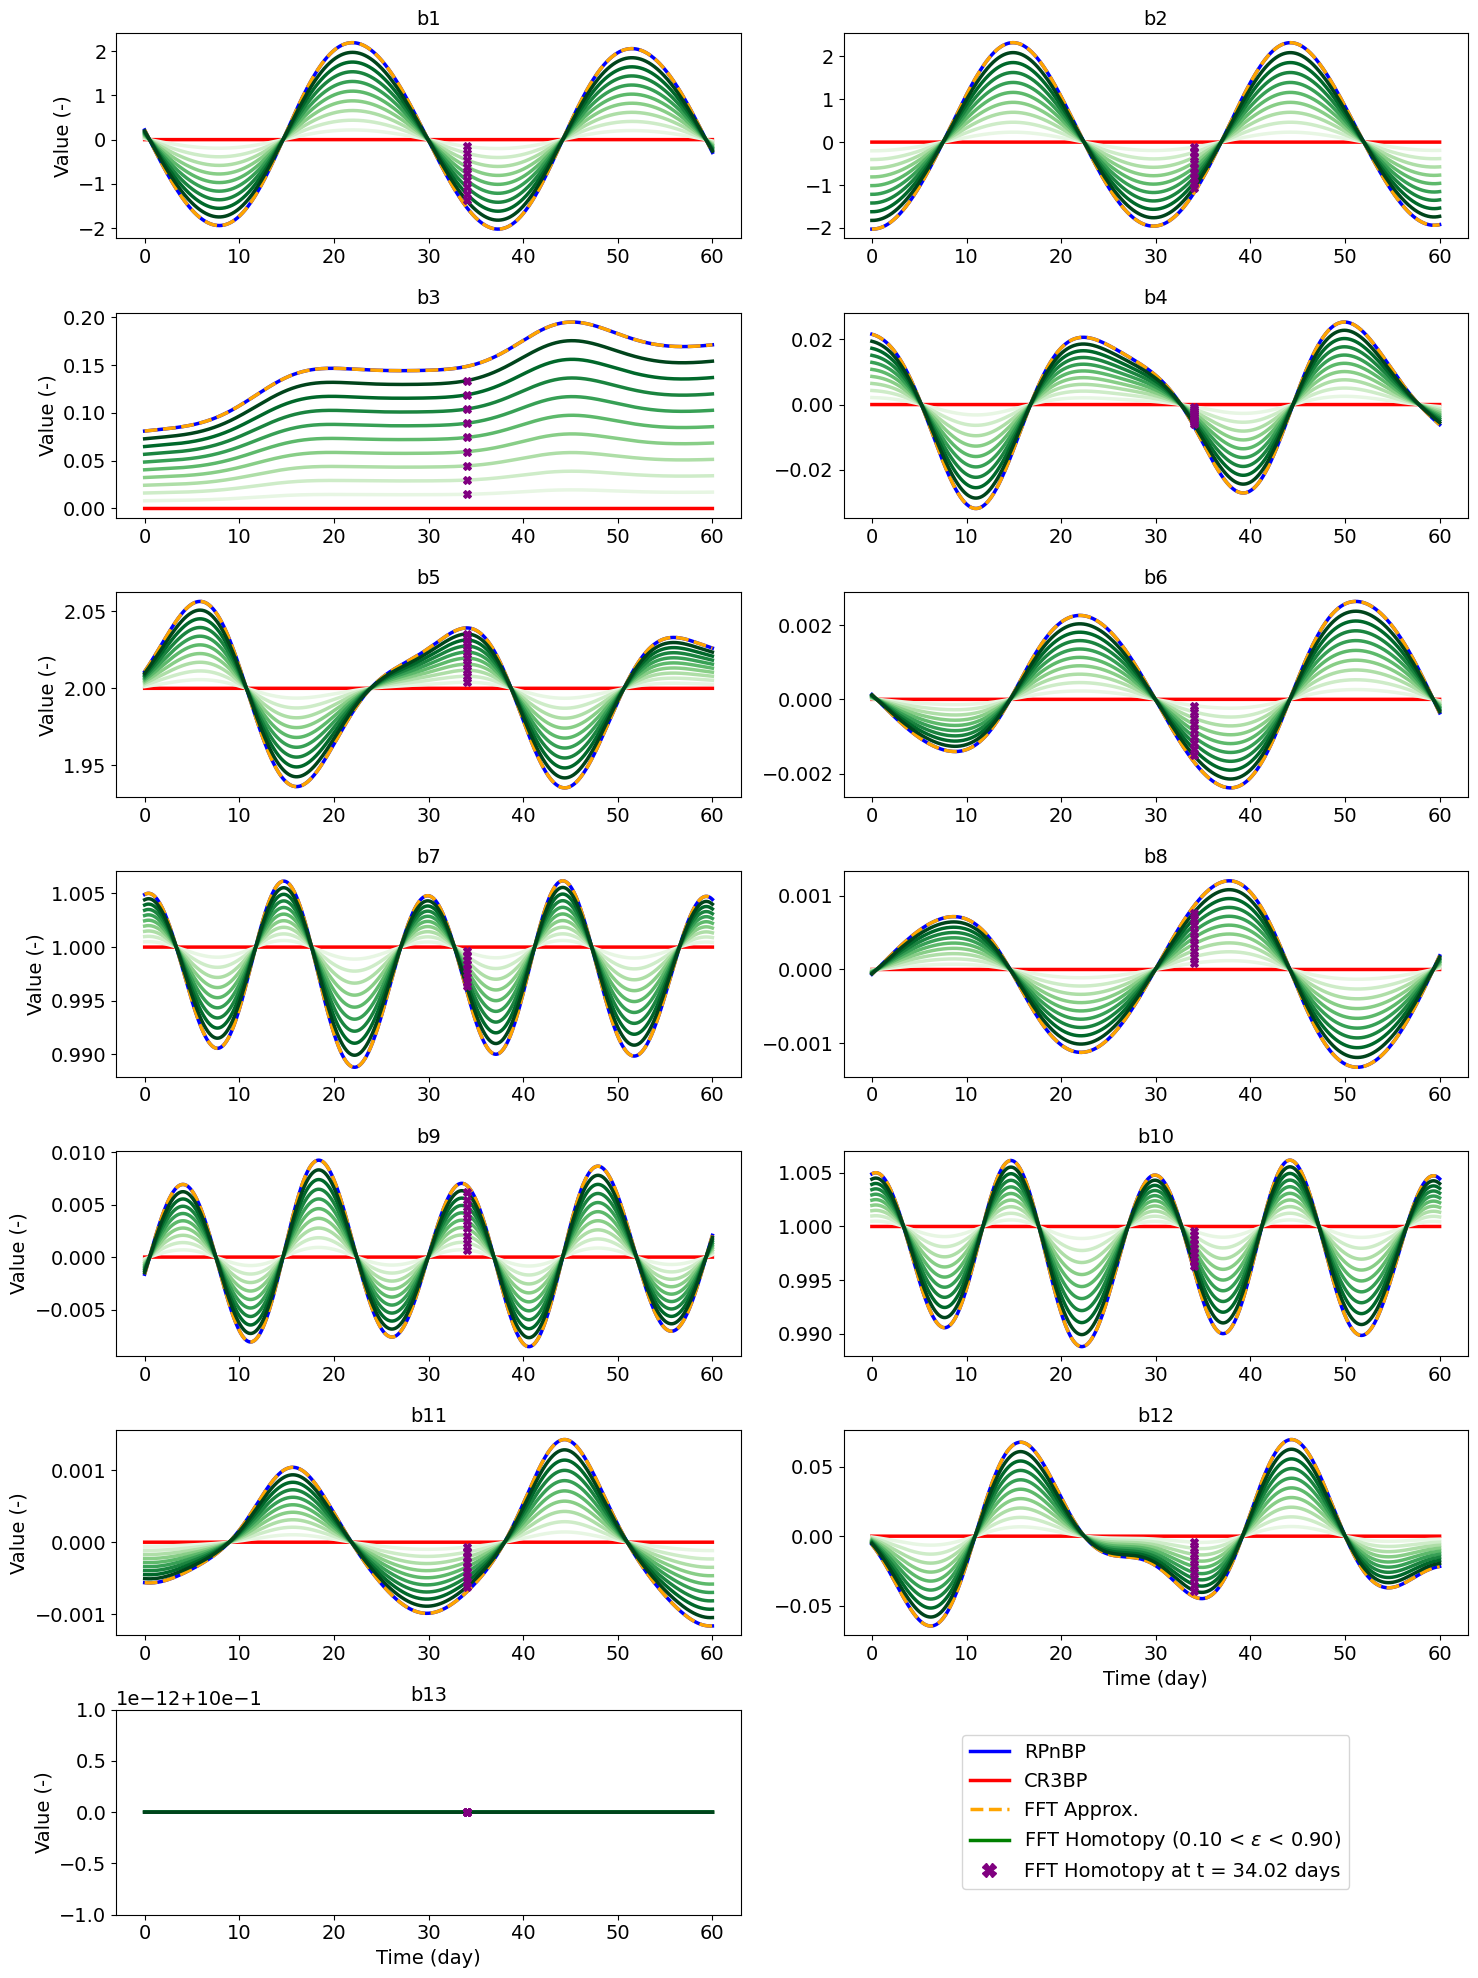

In [47]:
# Adimensional time
tau_linspace = np.linspace(0, om0 * ( epf - ep0 ), sel_points)

# Define n-body coefficients
b1 = np.zeros(sel_points) ; b2 = np.zeros(sel_points) ; b3 = np.zeros(sel_points) ; b4 = np.zeros(sel_points) ; b5 = np.zeros(sel_points) ; b6 = np.zeros(sel_points)
b7 = np.zeros(sel_points) ; b8 = np.zeros(sel_points) ; b9 = np.zeros(sel_points) ; b10 = np.zeros(sel_points) ; b11 = np.zeros(sel_points) ; b12 = np.zeros(sel_points) ; b13 = np.zeros(sel_points)
for i1 in range(len(tau_linspace)):
    b1[i1], b2[i1], b3[i1], b4[i1], b5[i1], b6[i1], b7[i1], b8[i1], b9[i1], b10[i1], b11[i1], b12[i1], b13[i1] = coeff_dynamics_nonuniform(tau_linspace[i1], rnbprpf_dict)

# Dimensional time (days)
tau_linspace = tau_linspace * TU / (60*60*24)

# Define 3BP coefficients
b_3bp = np.array([0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1])

# Select homotopy method and extrapolation point
sel_homotopy = 1 # 1: FFT ; 2: Piecewise ; 3: Polynomial
label_homotopy = ["FFT", "Piecewise", "Polynomial"]
x_point_val = 34.02  # The specific x-value you want to extrapolate from homotopy

# Define parameters for approximation methods
n_components_fft = 10000
num_segments_piecewise = 20
polynomial_degree = 3

# Compute homotopy
y = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13]
t_homotopy = 0.1
t_homotopy = np.arange(t_homotopy, 1, t_homotopy)
y_homotopy = np.zeros((len(y), len(t_homotopy), len(tau_linspace)))
y_approx = []
f_precomputed = []
for i1 in range(len(y)):
    if sel_homotopy == 1:
        y_approx.append( fft_approx_function(tau_linspace, fft(y[i1]), n_components_fft) )
        for i2 in range(len(t_homotopy)):
            y_homotopy[i1,i2,:] = general_homotopy(t_homotopy[i2], tau_linspace, y[i1], 'fft', n_components_fft, b_3bp[i1])

        # Precompute fft approximation
        f_precomputed.append(y_approx[i1])

    elif sel_homotopy == 2:
        y_approx.append( piecewise_linear_approx_function(tau_linspace, y[i1], num_segments_piecewise) )
        for i2 in range(len(t_homotopy)):
            y_homotopy[i1,i2,:] = general_homotopy(t_homotopy[i2], tau_linspace, y[i1], 'piecewise', num_segments_piecewise, b_3bp[i1])

        # Precompute interp1d function for Piecewise
        segment_indices = np.round(np.linspace(0, len(tau_linspace) - 1, num_segments_piecewise + 1)).astype(int)
        x_segments = tau_linspace[segment_indices]
        y_segments = y[i1][segment_indices]
        f_precomputed = interp1d(x_segments, y_segments) 

    elif sel_homotopy == 3:
        y_approx.append( polynomial_approx_function(tau_linspace, y[i1], polynomial_degree) )
        for i2 in range(len(t_homotopy)):
            y_homotopy[i1,i2,:] = general_homotopy(t_homotopy[i2], tau_linspace, y[i1], 'polynomial', polynomial_degree, b_3bp[i1])

        # Precompute polynomial coefficients
        f_precomputed.append(y_approx[i1])

# Evaluate homotopy at specific point using precomputed approximation
y_at_point = []
for i1 in range(len(y)):
    y_at_point.append(eval_homotopy_at_point(t_homotopy, tau_linspace, sel_homotopy, x_point_val, b_3bp[i1] * np.ones(len(tau_linspace)), f_precomputed[i1]))


# Plot
sel_linewidth = 2.5
sel_fontsize = 14
sel_markersize = 30
sel_markertype = "X"
plt.rcParams.update({'font.size': sel_fontsize})
figure, axes = plt.subplots(7, 2, figsize=(15, 20))

for i in range(len(y)):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(x_point_val * np.ones(len(t_homotopy)), y_at_point[i], color='purple', marker=sel_markertype, s=sel_markersize, zorder=5) 

axes[0, 0].plot(tau_linspace, b1, color='blue', linewidth=sel_linewidth)
axes[0, 0].plot(tau_linspace, b_3bp[0]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[0, 0].plot(tau_linspace, y_approx[0], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[0, 1].plot(tau_linspace, b2, color='blue', linewidth=sel_linewidth)
axes[0, 1].plot(tau_linspace, b_3bp[1]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[0, 1].plot(tau_linspace, y_approx[1], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[1, 0].plot(tau_linspace, b3, color='blue', linewidth=sel_linewidth)
axes[1, 0].plot(tau_linspace, b_3bp[2]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[1, 0].plot(tau_linspace, y_approx[2], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[1, 1].plot(tau_linspace, b4, color='blue', linewidth=sel_linewidth)
axes[1, 1].plot(tau_linspace, b_3bp[3]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[1, 1].plot(tau_linspace, y_approx[3], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[2, 0].plot(tau_linspace, b5, color='blue', linewidth=sel_linewidth)
axes[2, 0].plot(tau_linspace, b_3bp[4]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[2, 0].plot(tau_linspace, y_approx[4], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[2, 1].plot(tau_linspace, b6, color='blue', linewidth=sel_linewidth)
axes[2, 1].plot(tau_linspace, b_3bp[5]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[2, 1].plot(tau_linspace, y_approx[5], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[3, 0].plot(tau_linspace, b7, color='blue', linewidth=sel_linewidth)
axes[3, 0].plot(tau_linspace, b_3bp[6]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[3, 0].plot(tau_linspace, y_approx[6], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[3, 1].plot(tau_linspace, b8, color='blue', linewidth=sel_linewidth)
axes[3, 1].plot(tau_linspace, b_3bp[7]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[3, 1].plot(tau_linspace, y_approx[7], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[4, 0].plot(tau_linspace, b9, color='blue', linewidth=sel_linewidth)
axes[4, 0].plot(tau_linspace, b_3bp[8]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[4, 0].plot(tau_linspace, y_approx[8], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[4, 1].plot(tau_linspace, b10, color='blue', linewidth=sel_linewidth)
axes[4, 1].plot(tau_linspace, b_3bp[9]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[4, 1].plot(tau_linspace, y_approx[9], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[5, 0].plot(tau_linspace, b11, color='blue', linewidth=sel_linewidth)
axes[5, 0].plot(tau_linspace, b_3bp[10]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[5, 0].plot(tau_linspace, y_approx[10], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[5, 1].plot(tau_linspace, b12, color='blue', linewidth=sel_linewidth)
axes[5, 1].plot(tau_linspace, b_3bp[11]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[5, 1].plot(tau_linspace, y_approx[11], linestyle='--', color='orange', linewidth=sel_linewidth)

axes[6, 0].plot(tau_linspace, b13, color='blue', linewidth=sel_linewidth)
axes[6, 0].plot(tau_linspace, b_3bp[12]*np.ones(sel_points), color='red', linewidth=sel_linewidth)
axes[6, 0].plot(tau_linspace, y_approx[12], linestyle='--', color='orange', linewidth=sel_linewidth)

# Add homotopy lines to each subplot
gray_cmap = plt.colormaps['Greens']
for i in range(len(y)):  # Iterate through the coefficients (b1 to b13)
    row = i // 2  # Calculate subplot row index
    col = i % 2   # Calculate subplot column index

    for j, t in enumerate(t_homotopy):  # Iterate through the t_homotopy values and plot all of them
        color = gray_cmap((j + 1) / (len(t_homotopy)))
        axes[row, col].plot(tau_linspace, y_homotopy[i, j], linestyle='-', color=color, linewidth=sel_linewidth, label=label_homotopy[sel_homotopy-1]+f' Homotopy (t={t})') #different color for each t
        # axes[row, col].fill_between(tau_linspace, b_3bp[i] * np.ones_like(tau_linspace), y_homotopy[i, j], color=color, alpha=0.3)

    axes[row, col].set_title(f"b{i+1}", fontsize=sel_fontsize)

for ax in axes[6, :]:
    ax.set_xlabel("Time (day)", fontsize=sel_fontsize)  
axes[5, 1].set_xlabel("Time (day)", fontsize=sel_fontsize)  

for ax in axes[:, 0]:
    ax.set_ylabel("Value (-)", fontsize=sel_fontsize) 

for row, col in [(6, 0), (6,1)]:
    plt.setp(axes[row, col].get_xticklabels(), visible=True) 

RPnBP = plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=sel_linewidth, label='RPnBP') #create dummy lines to add to the legend
CR3BP = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=sel_linewidth,  label='CR3BP')
Approx = plt.Line2D([0], [0], color='orange', linestyle='--', linewidth=sel_linewidth,  label=label_homotopy[sel_homotopy-1]+' Approx.')
# Homotopy = [plt.Line2D([0], [0], linestyle='--', linewidth=sel_linewidth,  color=gray_cmap((j + 1) / (len(t_homotopy))), label=label_homotopy[sel_homotopy - 1] + f' Homotopy (t={t})') for j, t in enumerate(t_homotopy)]
# handles = [RPnBP, CR3BP, Approx, *Homotopy]
Homotopy = plt.Line2D([0], [0], linestyle='-', linewidth=sel_linewidth,  color='green', label=label_homotopy[sel_homotopy - 1] + f' Homotopy ({min(t_homotopy):.2f} < $\\epsilon$ < {max(t_homotopy):.2f})')
HomotopyPoints = plt.Line2D([0], [0], linestyle='none', marker=sel_markertype, markersize=10, color='purple', label=label_homotopy[sel_homotopy - 1] + f' Homotopy at t = {x_point_val:.2f} days') # 
handles = [RPnBP, CR3BP, Approx, Homotopy, HomotopyPoints]
axes[6, 1].legend(handles=handles, loc='center', fontsize=sel_fontsize) 
axes[6, 1].axis("off") 
plt.tight_layout()
plt.show()
#[np.float64(-6.001244240150692e-05), np.float64(6.108317228242551e-06), np.float64(-3.581916722733352e-06), 0.004482543909318961, 2.046945826458139, np.float64(-9.269185503776303e-06), 1.0000073655272128, np.float64(4.7433801454052964e-06), -0.00012890442849622342, np.float64(1.0000073655486923), np.float64(-8.387630506791255e-05), np.float64(-0.047489438564906374)]

In [ ]:
 398378.81099307083, 2.5262665061300883e-06, 6.382022459994723e-12, -0.03767870505510077, -7.627149524570698e-08, 3.584017822299959e-13]